In [1]:
import pandas as pd
import numpy as np
import re
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.constraints import MaxNorm
from keras.utils import to_categorical


from imblearn.over_sampling import ADASYN

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight


import keras
print(keras.__version__)

import tensorflow as tf
print(tf.__version__)

import sklearn
import sys
from collections import defaultdict

rs = 10
tf.random.set_seed(rs)
np.random.seed(rs)

print("scikit-learn version:", sklearn.__version__)
print("Python version:", sys.version)

3.10.0
2.19.0
scikit-learn version: 1.6.1
Python version: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]


In [4]:
path_i = r"I:\My Drive\Data_Collected\Apartments_processed_ML.csv"

In [5]:
col_study = ['t_sens', 't_satisf', 'daylight', 'dl_satisf', 'sound', 'sound_satisf', 'air_quali', 'o_satisf']
classes = ["Dissatisfied", "Neutral", "Satisfied"]

In [6]:
df = pd.read_csv(path_i)
df = df[col_study]
df

,t_sens,t_satisf,daylight,dl_satisf,sound,sound_satisf,air_quali,o_satisf
0,-1,3,3,1,3,1.0,3,1
1,0,5,1,1,5,1.0,4,2
2,-1,4,1,1,2,1.0,4,2
3,0,4,5,1,3,1.0,4,2
4,-2,4,2,0,2,1.0,4,2
...,...,...,...,...,...,...,...,...
809,1,5,3,1,5,1.0,4,2
810,-1,4,3,1,5,1.0,3,2
811,-1,5,3,1,2,1.0,3,2
812,-1,5,1,1,3,1.0,4,2


## NN Model

In [7]:
y = df['o_satisf'].values 

class_weights_array = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y),y=y)
class_weights = dict(enumerate(class_weights_array))
class_weights = None # Comment this line to run study using the class weights

print("Class weights:", class_weights)

Class weights: None


In [ ]:
X = df[['t_sens', 't_satisf', 'daylight', 'dl_satisf', 'sound', 'sound_satisf', 'air_quali']].values
y_raw = df['o_satisf'].values

encoder = LabelEncoder()
y_int = encoder.fit_transform(y_raw)
y_cat = to_categorical(y_int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rs = 100
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=rs)

recall_scores = defaultdict(list)
precision_scores = defaultdict(list)
f1_scores = defaultdict(list)
roc_auc_by_class = defaultdict(list)

precision_macro, f1_macro, precision_0_vs_2, roc_auc_macro = [], [], [], []
accuracy_scores = []


for train_idx, val_idx in cv.split(X_scaled, y_int):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train_int, y_val_int = y_int[train_idx], y_int[val_idx]


    sm = ADASYN(random_state=rs)
    #X_train, y_train_int = sm.fit_resample(X_train, y_train_int)

    y_train = to_categorical(y_train_int)
    y_val = to_categorical(y_val_int)

    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.1))
    model.add(Dense(60, kernel_initializer='normal', activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.1))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    model.compile(SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=400, batch_size=10, verbose=0, class_weight = class_weights, validation_data=(X_val, y_val))

    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true = np.argmax(y_val, axis=1)

    accuracy_scores.append(accuracy_score(y_val_true, y_val_pred_classes))


    for label in np.unique(y_val_true):
        recall_scores[label].append(recall_score(y_val_true, y_val_pred_classes, labels=[label], average='macro'))
        precision_scores[label].append(precision_score(y_val_true, y_val_pred_classes, labels=[label], average='macro'))
        f1_scores[label].append(f1_score(y_val_true, y_val_pred_classes, labels=[label], average='macro'))
        y_bin = (y_val_true == label).astype(int)
        roc_auc_by_class[label].append(roc_auc_score(y_bin, y_val_pred[:, label]))


    precision_macro.append(precision_score(y_val_true, y_val_pred_classes, average='macro'))
    f1_macro.append(f1_score(y_val_true, y_val_pred_classes, average='macro'))
    roc_auc_macro.append(roc_auc_score(y_val_true, y_val_pred, multi_class='ovo', average='macro'))


def mean_ci(metric_list):
    mean = np.mean(metric_list)
    ci = 1.96 * np.std(metric_list, ddof=1) / np.sqrt(len(metric_list))
    return mean, ci

print("\n=== Cross-Validation Metrics for NN Model (with 95% CI) ===")

acc_mean, acc_ci = mean_ci(accuracy_scores)
print(f"CV Score: {acc_mean:.2f} ± {acc_ci:.2f}")

for label in [0, 1, 2]:
    r_mean, r_ci = mean_ci(recall_scores[label])
    print(f"Recall - {label}: {r_mean:.2f} ± {r_ci:.2f}")

pm_mean, pm_ci = mean_ci(precision_macro)
print(f"Precision - Macro: {pm_mean:.2f} ± {pm_ci:.2f}")

for label in [0, 1, 2]:
    p_mean, p_ci = mean_ci(precision_scores[label])
    print(f"Precision - {label}: {p_mean:.2f} ± {p_ci:.2f}")

fm_mean, fm_ci = mean_ci(f1_macro)
print(f"F1 Score - Macro: {fm_mean:.2f} ± {fm_ci:.2f}")

for label in [0, 1, 2]:
    f_mean, f_ci = mean_ci(f1_scores[label])
    print(f"F1 Score - {label}: {f_mean:.2f} ± {f_ci:.2f}")

auc_macro_mean, auc_macro_ci = mean_ci(roc_auc_macro)
print(f"ROC AUC - Macro: {auc_macro_mean:.2f} ± {auc_macro_ci:.2f}")

for label in [0, 1, 2]:
    auc_mean, auc_ci = mean_ci(roc_auc_by_class[label])
    print(f"ROC AUC - {label}: {auc_mean:.2f} ± {auc_ci:.2f}")

In [8]:
rs = 22

X = df[['t_sens',  't_satisf', 'daylight', 'dl_satisf', 'sound', 'sound_satisf', 'air_quali']]
y = df['o_satisf']

X = X.values
nnscaler = StandardScaler()
X = nnscaler.fit(X).transform(X)
y = y.values

encoder = LabelEncoder()
y1 = encoder.fit_transform(y)
y = pd.get_dummies(y1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, stratify= y, random_state=rs)
sm = ADASYN(random_state=rs)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.80, random_state=rs)

n_cols = X_train.shape[1]
opt = SGD
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(Dropout(0.1))
model.add(Dense(60, kernel_initializer='normal', activation='relu', kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.1))
model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
model.compile(opt(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

nn_view = model.fit(X_train, y_train, epochs=400, batch_size=10, class_weight=class_weights, verbose=0, validation_data=(X_val, y_val))

y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test, axis = 1)
y_pred_class = np.argmax(y_pred, axis = 1)
score = model.evaluate(X_test, y_test)

print(classification_report(y_test_class,y_pred_class))

c:\Users\jucro\anaconda3\envs\Python_PhD\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8271 - loss: 0.5005  
              precision    recall  f1-score   support

           0       0.32      0.86      0.46         7
           1       0.40      0.68      0.50        28
           2       0.98      0.83      0.90       210

    accuracy                           0.81       245
   macro avg       0.56      0.79      0.62       245
weighted avg       0.89      0.81      0.84       245



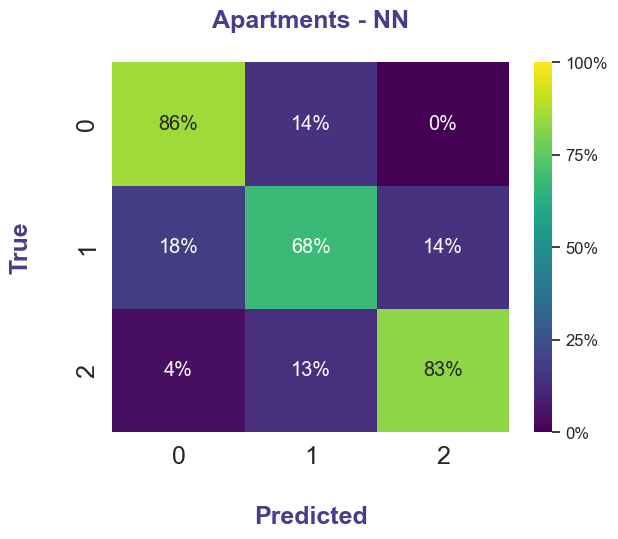

In [9]:
keras_conf_mx = confusion_matrix(y_test_class,y_pred_class, normalize = 'true')
sns.set_theme()
sns.set(font_scale=1.2)
cmap = "viridis"
ax = sns.heatmap(keras_conf_mx, cmap=cmap, annot=True, cbar=True, vmin=0, vmax=1,fmt='.0%')

plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.xlabel('Predicted', fontdict = {'fontweight': 'bold', 'fontsize': 18}, color = 'darkslateblue')
plt.ylabel('True', fontdict = {'fontweight': 'bold', 'fontsize': 18}, color = 'darkslateblue')
plt.title('Apartments - NN\n', fontdict = {'fontweight': 'bold', 'fontsize': 18}, color = 'darkslateblue')

cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, 0.50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'], fontsize = 12)
ax.tick_params(axis='both', which='major', labelsize=18)

ax.xaxis.set_label_coords(.5, -0.2)
ax.yaxis.set_label_coords(-0.2, .5)


In [ ]:
# Save NN model

joblib.dump(nnscaler, r'C:\scaler_home.pkl')
model.save(r'C:\home_nn_model.keras')

## RF Model

In [10]:

rs = 0
X = df[['t_sens', 't_satisf', 'daylight', 'dl_satisf', 'sound', 'sound_satisf', 'air_quali']].values
y = df['o_satisf'].values


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rs)


recall_scores = {label: [] for label in np.unique(y)}
precision_scores = {label: [] for label in np.unique(y)}
f1_scores = {label: [] for label in np.unique(y)}
roc_auc_by_class = {label: [] for label in np.unique(y)}

precision_macro, f1_macro, roc_auc_macro, accuracy_scores = [], [], [], []

for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    sm = ADASYN(random_state=rs)
    #X_train, y_train = sm.fit_resample(X_train, y_train)


    model = RandomForestClassifier(
        class_weight='balanced',
        n_estimators=300,
        n_jobs=-1,
        min_samples_leaf=3,
        min_samples_split=2,
        max_depth=10,
        bootstrap=False,
        random_state=100
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)

    accuracy_scores.append(accuracy_score(y_val, y_pred))

    for label in np.unique(y):
        recall_scores[label].append(recall_score(y_val, y_pred, labels=[label], average='macro'))
        precision_scores[label].append(precision_score(y_val, y_pred, labels=[label], average='macro'))
        f1_scores[label].append(f1_score(y_val, y_pred, labels=[label], average='macro'))

    precision_macro.append(precision_score(y_val, y_pred, average='macro'))
    f1_macro.append(f1_score(y_val, y_pred, average='macro'))
    roc_auc_macro.append(roc_auc_score(y_val, y_prob, multi_class='ovo', average='macro'))

    for label in np.unique(y):
        y_bin = (y_val == label).astype(int)
        roc_auc_by_class[label].append(roc_auc_score(y_bin, y_prob[:, label]))


def mean_ci(metric_list):
    mean = np.mean(metric_list)
    ci = 1.96 * np.std(metric_list, ddof=1) / np.sqrt(len(metric_list))
    return mean, ci


print("\n=== Cross-Validation Metrics with 95% Confidence Intervals ===")

acc_mean, acc_ci = mean_ci(accuracy_scores)
print(f"CV Accuracy: {acc_mean:.2f} ± {acc_ci:.2f}")

for label in [0, 1, 2]:
    r_mean, r_ci = mean_ci(recall_scores[label])
    print(f"Recall - {label}: {r_mean:.2f} ± {r_ci:.2f}")

pm_mean, pm_ci = mean_ci(precision_macro)
print(f"Precision - Macro: {pm_mean:.2f} ± {pm_ci:.2f}")

for label in [0, 1, 2]:
    p_mean, p_ci = mean_ci(precision_scores[label])
    print(f"Precision - {label}: {p_mean:.2f} ± {p_ci:.2f}")

fm_mean, fm_ci = mean_ci(f1_macro)
print(f"F1 Score - Macro: {fm_mean:.2f} ± {fm_ci:.2f}")

for label in [0, 1, 2]:
    f_mean, f_ci = mean_ci(f1_scores[label])
    print(f"F1 Score - {label}: {f_mean:.2f} ± {f_ci:.2f}")

auc_macro_mean, auc_macro_ci = mean_ci(roc_auc_macro)
print(f"ROC AUC - Macro: {auc_macro_mean:.2f} ± {auc_macro_ci:.2f}")

for label in [0, 1, 2]:
    auc_mean, auc_ci = mean_ci(roc_auc_by_class[label])
    print(f"ROC AUC - {label}: {auc_mean:.2f} ± {auc_ci:.2f}")


=== Cross-Validation Metrics with 95% Confidence Intervals ===
CV Accuracy: 0.88 ± 0.02
Recall - 0: 0.78 ± 0.15
Recall - 1: 0.76 ± 0.08
Recall - 2: 0.90 ± 0.01
Precision - Macro: 0.71 ± 0.06
Precision - 0: 0.65 ± 0.17
Precision - 1: 0.50 ± 0.07
Precision - 2: 0.98 ± 0.01
F1 Score - Macro: 0.74 ± 0.05
F1 Score - 0: 0.68 ± 0.14
F1 Score - 1: 0.60 ± 0.07
F1 Score - 2: 0.93 ± 0.01
ROC AUC - Macro: 0.90 ± 0.03
ROC AUC - 0: 0.95 ± 0.05
ROC AUC - 1: 0.91 ± 0.03
ROC AUC - 2: 0.95 ± 0.02


In [11]:
rs = 200

X = df[['t_sens', 't_satisf', 'daylight', 'dl_satisf', 'sound', 'sound_satisf', 'air_quali']]
y = df['o_satisf']

sm = ADASYN(random_state=rs)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, stratify=y, random_state=rs)
#X_train, y_train = sm.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(
    class_weight= 'balanced',
    n_estimators=300,
    n_jobs=-1,
    min_samples_leaf=3,
    min_samples_split=2,
    max_depth=10,
    bootstrap=False,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.63      0.86      0.73        28
           2       0.98      0.94      0.96       210

    accuracy                           0.93       245
   macro avg       0.87      0.88      0.87       245
weighted avg       0.94      0.93      0.93       245



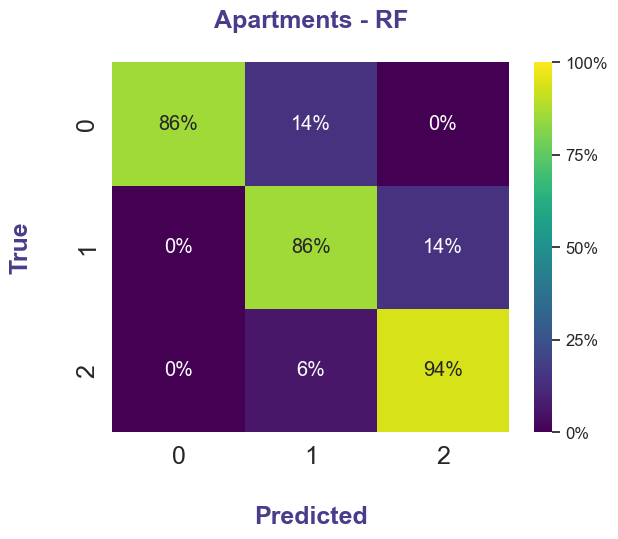

In [12]:
rf_conf_mx = confusion_matrix(y_test,y_pred, normalize='true')

sns.set_theme()
sns.set(font_scale=1.2)
cmap = "viridis"
ax = sns.heatmap(rf_conf_mx, cmap=cmap, annot=True, cbar=True, vmin=0, vmax=1, fmt='.0%')

plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.xlabel('Predicted', fontdict = {'fontweight': 'bold', 'fontsize': 18}, color = 'darkslateblue')
plt.ylabel('True', fontdict = {'fontweight': 'bold', 'fontsize': 18}, color = 'darkslateblue')
plt.title('Apartments - RF\n', fontdict = {'fontweight': 'bold', 'fontsize': 18}, color = 'darkslateblue')

cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, 0.50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'], fontsize = 12)
ax.tick_params(axis='both', which='major', labelsize=18)

ax.xaxis.set_label_coords(.5, -0.2)
ax.yaxis.set_label_coords(-0.2, .5)


In [ ]:
##Save RF model

joblib.dump(rf_model, r'C:\home_rf_model.joblib')